In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
df_structures = pd.read_csv(FOLDER + 'structures.csv')
df = pd.read_csv(FOLDER + 'train.csv')

In [4]:
df_structures_idx = df_structures.set_index("molecule_name")
df_idx = df.set_index("molecule_name")

In [5]:
mols = df['molecule_name'].unique()

In [6]:
def get_dist_matrix(df_structures_idx, molecule):
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = np.sqrt(((loc_tile - loc_tile.T)**2).sum(axis=1))
    return dist_mat

In [7]:
first_submission_name = '20190721_submission.csv'

In [20]:
# map_test_pickle = '20190727_map_test.pickle'
# df_map_test = pd.read_pickle(OUTPUT + map_test_pickle)

In [21]:
df_sub = pd.read_csv(OUTPUT + first_submission_name)
df_test = pd.read_csv(FOLDER + 'test.csv')
df_test_merge = pd.merge(df_test, df_sub, on=['id'], how='inner').rename(columns={'scalar_coupling_constant':'predict'})
df_test_merge.head()

,id,molecule_name,atom_index_0,atom_index_1,type,predict
0,4658147,dsgdb9nsd_000004,2,0,2JHC,17.965293
1,4658148,dsgdb9nsd_000004,2,1,1JHC,197.038690
2,4658149,dsgdb9nsd_000004,2,3,3JHH,12.069346
3,4658150,dsgdb9nsd_000004,3,0,1JHC,197.038690
4,4658151,dsgdb9nsd_000004,3,1,2JHC,17.965293


In [22]:
print(df_test.shape, df_sub.shape, df_test_merge.shape)

(2505542, 5) (2505542, 2) (2505542, 6)


In [18]:
df_test_merge_idx = df_test_merge.set_index('molecule_name')

In [ ]:
 gen_second_data(df_test_merge_idx, df_sc_map_idx, m, target_col='scalar_coupling_constant'):

In [138]:
df_idx.loc[mols[0]].index.values

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000001', 'dsgdb9nsd_000001',
       'dsgdb9nsd_000001', 'dsgdb9nsd_000001', 'dsgdb9nsd_000001',
       'dsgdb9nsd_000001', 'dsgdb9nsd_000001', 'dsgdb9nsd_000001',
       'dsgdb9nsd_000001'], dtype=object)

In [139]:
def pickup_bond_dist(df_mol_idx_0, dist_arr, bond):
    df_mol_idx_b = df_mol_idx_0.query('type == "{}"'.format(bond))
    atoms_b = df_mol_idx_b['atom_index_1'].values
    dist_b = dist_arr[atoms_b]       
    sorting_b = np.argsort(dist_b)
    idx_b = df_mol_idx_b.index.values
    return idx_b[sorting_b], 1/dist_arr[atoms_b][sorting_b]

In [214]:
def gen_map_dist(df_idx, df_structures_idx, m):
    
    bonds = ['1JHC', '1JHN', '2JHH', '2JHC', '2JHN', '3JHH', '3JHC', '3JHN']
    
    if type(df_idx.loc[m]) == pd.Series:

        idx_0 = np.ones([1+len(bonds)*3*2]) * (-1)
        dist_0 = np.zeros([1+len(bonds)*3*2])

        df_idx_out = pd.DataFrame(idx_0, dtype='int32').T
        df_idx_out['id'] = df_idx.loc[m]['id']
        df_idx_out['molecule_name'] = m

        df_dist_out = pd.DataFrame(dist_0, dtype='float32').T
        df_dist_out['id'] = df_idx.loc[m]['id']
        df_dist_out['molecule_name'] = m

        return df_idx_out, df_dist_out
    
    dist_mat = get_dist_matrix(df_structures_idx, m)    

    df_idx_out_all = pd.DataFrame()
    df_dist_out_all = pd.DataFrame()
    
    for target_bond in bonds:

        df_mol = df_idx.loc[m]
        con_id = df_mol.query('type == "{}"'.format(target_bond))['id'].values
        if len(con_id) == 0:
            continue
            
        df_mol_idx = df_mol.set_index('id')

        idx_01 = np.ones(len(con_id)) * (-1)
        idx_0 = np.ones([len(con_id), len(bonds)*3]) * (-1)
        idx_1 = np.ones([len(con_id), len(bonds)*3]) * (-1)

        dist_01 = np.zeros(len(con_id))
        dist_0 = np.zeros([len(con_id), len(bonds)*3])
        dist_1 = np.zeros([len(con_id), len(bonds)*3])

        for i, idx in enumerate(con_id):
            focus_0 = df_mol_idx.loc[idx]['atom_index_0']
            focus_1 = df_mol_idx.loc[idx]['atom_index_1']

            dist_arr = dist_mat[focus_0]
            idx_01[i] = idx
            dist_01[i] = 1/dist_arr[focus_1]

            df_mol_idx_0 = df_mol_idx.loc[df_mol_idx.index != idx].query('atom_index_0 == {}'.format(focus_0))
            for j, b in enumerate(bonds):
                con_b_idx, inv_dist = pickup_bond_dist(df_mol_idx_0, dist_arr, b)
                num_atoms = len(con_b_idx)
                if num_atoms == 0:
                    continue
                if num_atoms > 3:
                    idx_0[i, j*3:(j+1)*3] = con_b_idx[:3]
                    dist_0[i, j*3:(j+1)*3] = inv_dist[:3]
                else:
                    idx_0[i, j*3:j*3+num_atoms] = con_b_idx
                    dist_0[i, j*3:j*3+num_atoms] = inv_dist

            df_mol_idx_1 = df_mol_idx.loc[df_mol_idx.index != idx].query('atom_index_1 == {}'.format(focus_1))
            for j, b in enumerate(bonds):
                con_b_idx, inv_dist = pickup_bond_dist(df_mol_idx_1, dist_arr, b)
                num_atoms = len(con_b_idx)
                if num_atoms == 0:
                    continue
                if num_atoms > 3:     
                    idx_1[i, j*3:(j+1)*3] = con_b_idx[:3]
                    dist_1[i, j*3:(j+1)*3] = inv_dist[:3]
                else:
                    idx_1[i, j*3:j*3+num_atoms] = con_b_idx
                    dist_1[i, j*3:j*3+num_atoms] = inv_dist

        idx_all = np.hstack([idx_01.reshape(-1,1), idx_0, idx_1])
        dist_all = np.hstack([dist_01.reshape(-1,1), dist_0, dist_1])

        df_idx_out = pd.DataFrame(idx_all, dtype='int32')
        df_idx_out['id'] = con_id
        df_idx_out['molecule_name'] = m

        df_dist_out = pd.DataFrame(dist_all, dtype='float32')
        df_dist_out['id'] = con_id
        df_dist_out['molecule_name'] = m
        
        df_idx_out_all = pd.concat([df_idx_out_all, df_idx_out], axis=0)
        df_dist_out_all = pd.concat([df_dist_out_all, df_dist_out], axis=0)
                
    return df_idx_out_all, df_dist_out_all

In [215]:
df_sc_map, df_bond_length = gen_map_dist(df_idx, df_structures_idx, mols[0])

In [227]:
df_sc_map_temp[cols].replace(id_sc_map).values.shape

(10, 49)

In [250]:
m = mols[0]

df_sc_map_idx = df_sc_map.set_index("molecule_name")
df_sc_map_temp = df_sc_map_idx.loc[m]

id_sc_map = dict(df_idx.loc[m][['id', 'scalar_coupling_constant']].values)
id_sc_map[-1] = 0
id_sc_map

cols = list(df_sc_map_temp.columns)
cols.remove('id')
ids = pd.DataFrame(df_sc_map_temp['id']).reset_index()
del ids['molecule_name']
df_bond_sc = pd.concat([ids, df_sc_map_temp[cols].replace(id_sc_map).reset_index()], axis=1)
df_bond_sc

,id,molecule_name,0,1,2,3,4,5,6,7,...,39,40,41,42,43,44,45,46,47,48
0,0,dsgdb9nsd_000001,84.8076,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,dsgdb9nsd_000001,84.8074,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,dsgdb9nsd_000001,84.8093,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,dsgdb9nsd_000001,84.8095,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,dsgdb9nsd_000001,-11.2570,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,dsgdb9nsd_000001,-11.2548,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3,dsgdb9nsd_000001,-11.2543,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5,dsgdb9nsd_000001,-11.2541,84.8074,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6,dsgdb9nsd_000001,-11.2548,84.8074,0.0,0.0,0.0,0.0,0.0,-11.2541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8,dsgdb9nsd_000001,-11.2543,84.8093,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [256]:
df_sc_map_idx = df_sc_map.set_index("molecule_name")

In [257]:
def gen_second_data(df_idx, df_sc_map_idx, m, target_col='scalar_coupling_constant'):
    df_sc_map_temp = df_sc_map_idx.loc[m]

    id_sc_map = dict(df_idx.loc[m][['id', target_col]].values)
    id_sc_map[-1] = 0
    id_sc_map

    cols = list(df_sc_map_temp.columns)
    cols.remove('id')
    ids = pd.DataFrame(df_sc_map_temp['id']).reset_index()
    del ids['molecule_name']
    df_bond_sc = pd.concat([ids, df_sc_map_temp[cols].replace(id_sc_map).reset_index()], axis=1)
    return df_bond_sc

In [258]:
gen_second_data(df_idx, df_sc_map_idx, mols[0])

,id,molecule_name,0,1,2,3,4,5,6,7,...,39,40,41,42,43,44,45,46,47,48
0,0,dsgdb9nsd_000001,84.8076,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,dsgdb9nsd_000001,84.8074,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,dsgdb9nsd_000001,84.8093,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,dsgdb9nsd_000001,84.8095,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,dsgdb9nsd_000001,-11.2570,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,dsgdb9nsd_000001,-11.2548,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3,dsgdb9nsd_000001,-11.2543,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5,dsgdb9nsd_000001,-11.2541,84.8074,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6,dsgdb9nsd_000001,-11.2548,84.8074,0.0,0.0,0.0,0.0,0.0,-11.2541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8,dsgdb9nsd_000001,-11.2543,84.8093,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
ids = df_idx.loc[mols[0]]['id'].values
scs = df_idx.loc[mols[0]]['scalar_coupling_constant'].values

{0.0: 84.8076,
 1.0: -11.257,
 2.0: -11.2548,
 3.0: -11.2543,
 4.0: 84.8074,
 5.0: -11.2541,
 6.0: -11.2548,
 7.0: 84.8093,
 8.0: -11.2543,
 9.0: 84.8095,
 -1: 0}

In [207]:
cols = list(a.columns)
cols.remove('id')
cols.remove('molecule_name')
ids = a['id']
mol_names = a['molecule_name']
pd.concat([ids, mol_names, a[cols].replace(id_sc_map)], axis=1)

,id,molecule_name,0,1,2,3,4,5,6,7,...,39,40,41,42,43,44,45,46,47,48
0,0,dsgdb9nsd_000001,84.8076,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,dsgdb9nsd_000001,84.8074,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,dsgdb9nsd_000001,84.8093,0.0000,0.0,0.0,0.0,0.0,0.0,-11.2543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,dsgdb9nsd_000001,84.8095,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,dsgdb9nsd_000001,-11.2570,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,dsgdb9nsd_000001,-11.2548,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,dsgdb9nsd_000001,-11.2543,84.8076,0.0,0.0,0.0,0.0,0.0,-11.2570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,dsgdb9nsd_000001,-11.2541,84.8074,0.0,0.0,0.0,0.0,0.0,-11.2548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,dsgdb9nsd_000001,-11.2548,84.8074,0.0,0.0,0.0,0.0,0.0,-11.2541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,8,dsgdb9nsd_000001,-11.2543,84.8093,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df_structures_idx.loc[m]

,atom_index,atom,x,y,z
molecule_name,,,,,
dsgdb9nsd_000004,0,C,0.599539,0.0,1.0
dsgdb9nsd_000004,1,C,-0.599539,0.0,1.0
dsgdb9nsd_000004,2,H,-1.661639,0.0,1.0
dsgdb9nsd_000004,3,H,1.661639,0.0,1.0


In [38]:
gen_second_data(df_idx, df_structures_idx, m, target_bond='1JHC', target_col='scalar_coupling_constant')

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,id
0,999.0,0.941532,0.0,0.0,0.0,0.0,0.0,0.0,999.0,0.0,...,0.0,0.0,0.0,999.0,0.0,0.0,0.300908,0.0,0.0,4658148
1,999.0,0.941532,0.0,0.0,0.0,0.0,0.0,0.0,999.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4658150


In [13]:
def c_neighbor(df_structures_idx, mol, thres=1.65):
    dist_mat = get_dist_matrix(df_structures_idx, mol)
    atom_arr = df_structures_idx.loc[mol]["atom"].values
    df_temp = df_structures_idx.loc[mol]
    num_atoms = df_temp.shape[0]

    c_idx = df_temp[df_temp['atom'] == 'C']['atom_index'].values

    neighbor_idx = {}
    neighbor_atoms = {}
#     neighbor_dist = {}

    for i in c_idx:
        dist_argsort = np.argsort(dist_mat[i])
        near_1_idx = dist_argsort[1]
        near_2_idx = dist_argsort[2]
        try:
            near_3_idx = dist_argsort[3]
            if  dist_mat[i][near_3_idx] < thres:
                try:
                    near_4_idx = dist_argsort[4]
                    if  dist_mat[i][near_4_idx] < thres:
                        neighbor_idx[i] = np.array([near_1_idx, near_2_idx, near_3_idx, near_4_idx])
                        neighbor_atoms[i] = atom_arr[neighbor_idx[i]]
#                         neighbor_dist[i] = dist_mat[i][[neighbor_idx[i]]]
                    else:
                        neighbor_idx[i] = np.array([near_1_idx, near_2_idx, near_3_idx, -1])
                        atoms = atom_arr[np.array([neighbor_idx[i][:3]])][0]
                        neighbor_atoms[i] =  np.hstack([atoms, "X"])
#                         dists = dist_mat[i][neighbor_idx[i][:3]][0]
#                         neighbor_dist[i] = np.hstack([dists, 0.0])
                except:
                    neighbor_idx[i] = np.array([near_1_idx, near_2_idx, near_3_idx, -1])
                    atoms = atom_arr[neighbor_idx[i][:3]][0]
                    neighbor_atoms[i] =  np.hstack([atoms, "X"])
#                     dists = dist_mat[i][neighbor_idx[i][:3]][0]
#                     neighbor_dist[i] = np.hstack([dists, 0.0])
            else:
                neighbor_idx[i] = np.array([near_1_idx, near_2_idx, -1, -1])
                atoms = atom_arr[neighbor_idx[i][:2]][0]
                neighbor_atoms[i] =  np.hstack([atoms, "X", "X"])
#                 dists = dist_mat[i][neighbor_idx[i][:2]][0]
#                 neighbor_dist[i] = np.hstack([dists, 0.0, 0.0])
        except:
            neighbor_idx[i] = np.array([near_1_idx, near_2_idx, -1, -1])
            atoms = atom_arr[neighbor_idx[i][:2]][0]
            neighbor_atoms[i] =  np.hstack([atoms, "X", "X"])
#             dists = dist_mat[i][neighbor_idx[i][:2]][0]
#             neighbor_dist[i] = np.hstack([dists, 0.0, 0.0])

    return neighbor_idx, neighbor_atoms#, neighbor_dist

In [11]:
def pickup_neighbors(i, neighbors):
    return neighbors[i]

In [52]:
def gen_df_1JHC(df_idx, df_structures_idx, m):
#     neighbors_idx, neighbors_atom, neighbors_dist = c_neighbor(df_structures_idx, m)
    neighbors_idx, neighbors_atom = c_neighbor(df_structures_idx, m)
    
    df_idx_temp = df_idx.loc[m]
    if type(df_idx_temp) == pd.Series:
        return
    
    df_1JHC_temp = df_idx_temp.query('type == "1JHC"')

    atom_arrays = df_1JHC_temp['atom_index_1'].apply(pickup_neighbors, neighbors=neighbors_atom).values
    idx_arrays = df_1JHC_temp['atom_index_1'].apply(pickup_neighbors, neighbors=neighbors_idx).values
    # dist_arrays = df_1JHC_temp['atom_index_1'].apply(pickup_neighbors, neighbors=neighbors_dist)

    idx_arr = np.zeros([0,4])
    atom_arr = np.zeros([0,4])
    
    # dist_arr = np.zeros([0,4])
    print(idx_arrays)
    print(atom_arrays)
    
    for i, idx in enumerate(idx_arrays):
        idx_arr = np.vstack([idx_arr, idx])
        atom_arr = np.vstack([atom_arr, atom_arrays[i]])
    #     dist_arr = np.vstack([dist_arr, dist_arrays[i]])
    
#     if type(df_1JHC_temp) == pd.Series:
#         return

    for j in range(4):
        df_1JHC_temp.loc[:]['neig_idx_{}'.format(j)] = idx_arr[:,j]
        df_1JHC_temp.loc[:]['neig_atom_{}'.format(j)] = atom_arr[:,j]
    #     df_1JHC_temp['neig_dist_{}'.format(j)] = dist_arr[:,j]

    return df_1JHC_temp

In [57]:
gen_df_1JHC(df_idx, df_structures_idx, mols[5])

[array([4, 3, 2, 1]) array([4, 3, 2, 1]) array([4, 3, 2, 1])]
[array(['H', 'H', 'H', 'O'], dtype=object)
 array(['H', 'H', 'H', 'O'], dtype=object)
 array(['H', 'H', 'H', 'O'], dtype=object)]


,id,atom_index_0,atom_index_1,type,scalar_coupling_constant
molecule_name,,,,,
dsgdb9nsd_000008,46,2,0,1JHC,87.6326
dsgdb9nsd_000008,50,3,0,1JHC,87.6253
dsgdb9nsd_000008,53,4,0,1JHC,90.0888


In [59]:
h_idx = df_idx.loc[mols[10]]['atom_index_0'].unique()
df_idx.loc[mols[10]].query('atom_index_0 == "{}"'.format(h_idx[0]))

,id,atom_index_0,atom_index_1,type,scalar_coupling_constant
molecule_name,,,,,
dsgdb9nsd_000013,106,3,0,1JHC,83.51320
dsgdb9nsd_000013,107,3,1,2JHC,-2.03004
dsgdb9nsd_000013,108,3,2,3JHC,2.51277
dsgdb9nsd_000013,109,3,4,2JHH,-11.43170
dsgdb9nsd_000013,110,3,5,2JHH,-11.47950
dsgdb9nsd_000013,111,3,6,3JHH,3.42929
dsgdb9nsd_000013,112,3,7,3JHH,12.33070


In [137]:
m = mols[9]
neighbors_idx, neighbors_atom, neighbors_dist= c_neighbor(df_structures_idx, m)
df_idx_temp = df_idx.loc[m]

df_1JHC_temp = df_idx_temp.query('type == "1JHC"')

atom_arrays = df_1JHC_temp['atom_index_1'].apply(pickup_neighbors, neighbors=neighbors_atom)
idx_arrays = df_1JHC_temp['atom_index_1'].apply(pickup_neighbors, neighbors=neighbors_idx)
# dist_arrays = df_1JHC_temp['atom_index_1'].apply(pickup_neighbors, neighbors=neighbors_dist)

num = len(idx_arrays)
idx_arr = np.zeros([0,4])
atom_arr = np.zeros([0,4])
# dist_arr = np.zeros([0,4])
for i in range(num):
    idx_arr = np.vstack([idx_arr, idx_arrays[i]])
    atom_arr = np.vstack([atom_arr, atom_arrays[i]])
#     dist_arr = np.vstack([dist_arr, dist_arrays[i]])

for j in range(4):
    df_1JHC_temp['neig_idx_{}'.format(j)] = idx_arr[:,j]
    df_1JHC_temp['neig_atom_{}'.format(j)] = atom_arr[:,j]
#     df_1JHC_temp['neig_dist_{}'.format(j)] = dist_arr[:,j]
    

df_1JHC_temp

/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,atom_index_0,atom_index_1,type,scalar_coupling_constant,neig_idx_0,neig_atom_0,neig_idx_1,neig_atom_1,neig_idx_2,neig_atom_2,neig_idx_3,neig_atom_3
molecule_name,,,,,,,,,,,,,
dsgdb9nsd_000012,105,5,1,1JHC,109.301,5.0,H,2.0,O,0.0,N,-1.0,X


In [165]:
start = time.time()
df_1JHC = pd.DataFrame()

for m in mols[:100]:
    df_1JHC_temp = gen_df_1JHC(df_idx, df_structures_idx, m)
    df_1JHC = pd.concat([df_1JHC, df_1JHC_temp], axis=0)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

elapsed_time:16.08162212371826[sec]


In [166]:
df_1JHC.head()

,id,atom_index_0,atom_index_1,type,scalar_coupling_constant,neig_idx_0,neig_atom_0,neig_idx_1,neig_atom_1,neig_idx_2,neig_atom_2,neig_idx_3,neig_atom_3
dsgdb9nsd_000001,0,1,0,1JHC,84.8076,3.0,H,4.0,H,2.0,H,1.0,H
dsgdb9nsd_000001,4,2,0,1JHC,84.8074,3.0,H,4.0,H,2.0,H,1.0,H
dsgdb9nsd_000001,7,3,0,1JHC,84.8093,3.0,H,4.0,H,2.0,H,1.0,H
dsgdb9nsd_000001,9,4,0,1JHC,84.8095,3.0,H,4.0,H,2.0,H,1.0,H
dsgdb9nsd_000005,17,2,0,1JHC,171.2200,2.0,H,1.0,N,-1.0,X,-1.0,X


In [91]:
pd.merge(df_1JHC.reset_index(), df_structures[['molecule_name', "atom_index", 'atom']],
          left_on=['index', 'neighbor_0'], right_on=['molecule_name', 'atom_index'])

,index,id,atom_index_0,atom_index_1,type,scalar_coupling_constant,neighbor_0,neighbor_1,neighbor_2,neighbor_3,molecule_name,atom_index,atom
0,dsgdb9nsd_000001,0,1,0,1JHC,84.8076,3.0,4.0,2.0,1.0,dsgdb9nsd_000001,3,H
1,dsgdb9nsd_000001,4,2,0,1JHC,84.8074,3.0,4.0,2.0,1.0,dsgdb9nsd_000001,3,H
2,dsgdb9nsd_000001,7,3,0,1JHC,84.8093,3.0,4.0,2.0,1.0,dsgdb9nsd_000001,3,H
3,dsgdb9nsd_000001,9,4,0,1JHC,84.8095,3.0,4.0,2.0,1.0,dsgdb9nsd_000001,3,H
4,dsgdb9nsd_000005,17,2,0,1JHC,171.2200,2.0,1.0,NaN,NaN,dsgdb9nsd_000005,2,H
5,dsgdb9nsd_000007,19,2,0,1JHC,83.5429,2.0,3.0,4.0,1.0,dsgdb9nsd_000007,2,H
6,dsgdb9nsd_000007,26,3,0,1JHC,83.5417,2.0,3.0,4.0,1.0,dsgdb9nsd_000007,2,H
7,dsgdb9nsd_000007,32,4,0,1JHC,83.5484,2.0,3.0,4.0,1.0,dsgdb9nsd_000007,2,H
8,dsgdb9nsd_000007,38,5,1,1JHC,83.5418,6.0,5.0,7.0,0.0,dsgdb9nsd_000007,6,H
9,dsgdb9nsd_000007,42,6,1,1JHC,83.5430,6.0,5.0,7.0,0.0,dsgdb9nsd_000007,6,H


In [74]:
df_structures_idx.loc[mols[101]]

,atom_index,atom,x,y,z
molecule_name,,,,,
dsgdb9nsd_000145,0,O,-0.075590,0.023195,-0.230479
dsgdb9nsd_000145,1,C,0.042680,1.172038,0.114793
dsgdb9nsd_000145,2,C,1.299166,1.949935,0.077156
dsgdb9nsd_000145,3,C,1.204133,3.441405,-0.218915
dsgdb9nsd_000145,4,C,1.523206,2.992878,1.164938
dsgdb9nsd_000145,5,H,-0.831024,1.751502,0.503765
dsgdb9nsd_000145,6,H,2.159951,1.407769,-0.297029
dsgdb9nsd_000145,7,H,1.991487,3.863990,-0.831667
dsgdb9nsd_000145,8,H,0.216792,3.848035,-0.411964


In [4]:
def get_dist_matrix(df_structures_idx, molecule):
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = np.linalg.norm(loc_tile - loc_tile.T, axis=1)
    return dist_mat

In [6]:
df = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')

In [7]:
mols = df['molecule_name'].unique()

In [8]:
df_structures_idx = df_structures.set_index('molecule_name')
df_idx = df.set_index('molecule_name')

In [9]:
df_idx.loc[mols[729]]

,id,atom_index_0,atom_index_1,type,scalar_coupling_constant
molecule_name,,,,,
dsgdb9nsd_001230,25204,7,0,1JHN,52.537100
dsgdb9nsd_001230,25205,7,1,2JHC,-1.805230
dsgdb9nsd_001230,25206,7,3,3JHN,2.306570
dsgdb9nsd_001230,25207,7,8,2JHH,-1.561860
dsgdb9nsd_001230,25208,8,0,1JHN,49.223500
dsgdb9nsd_001230,25209,8,1,2JHC,0.599520
dsgdb9nsd_001230,25210,8,3,3JHN,-0.248613
dsgdb9nsd_001230,25211,9,0,3JHN,-0.143125
dsgdb9nsd_001230,25212,9,1,2JHC,3.361070


In [10]:
dist_arr_1JHC = np.zeros(0)
for m in mols[:5000]:
    dist_mat = get_dist_matrix(df_structures_idx, m)
    if type(df_idx.loc[m]) ==  pd.Series:
        continue
    idx  = df_idx.loc[m].query('type == "1JHC"')[['atom_index_0', 'atom_index_1']].values
    for i in idx:
        dist_arr_1JHC = np.hstack([dist_arr_1JHC, dist_mat[i[0], i[1]]])
        
dist_arr_1JHN = np.zeros(0)
for m in mols[:5000]:
    dist_mat = get_dist_matrix(df_structures_idx, m)
    if type(df_idx.loc[m]) ==  pd.Series:
        continue
    idx  = df_idx.loc[m].query('type == "1JHN"')[['atom_index_0', 'atom_index_1']].values
    for i in idx:
        dist_arr_1JHN = np.hstack([dist_arr_1JHN, dist_mat[i[0], i[1]]])

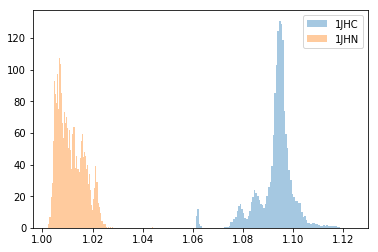

In [11]:
sns.distplot(dist_arr_1JHC, bins=100, kde=False, norm_hist=True, label='1JHC')
sns.distplot(dist_arr_1JHN, bins=100, kde=False, norm_hist=True, label='1JHN')
plt.legend()
plt.show()

In [29]:
def gen_3JHN_list(df_idx, df_structures_idx, molecule_name):
    pairs_list = []
    df_tr = df_idx.loc[molecule_name]
    df_st = df_structures_idx.loc[molecule_name]

    if type(df_tr) == pd.Series:
        return []

    pairs_3J = df_tr.query('type == "{}"'.format('3JHN'))[['atom_index_0','atom_index_1','id']].values
    dist_matrix = get_dist_matrix(df_structures_idx, molecule_name)

    for p3 in pairs_3J:
        atom_idx_0 = p3[0] 
        con_id = p3[2] 

        dist_arr = dist_matrix[atom_idx_0] 
        mask = dist_arr != 0
        dist_arr_excl_0 = dist_arr[mask]
        masked_idx = df_st['atom_index'].values[mask]
        atom_idx_1 = masked_idx[np.argsort(dist_arr_excl_0)[0]]

        atom_idx_3 = p3[1]
        dist_arr = dist_matrix[atom_idx_3]
        candidate_atom_idx_2 = np.arange(len(dist_arr))[(dist_arr > 1.1) * (dist_arr < 1.65)]
        atom_idx_2 = candidate_atom_idx_2[np.argsort(dist_matrix[atom_idx_1][candidate_atom_idx_2])[0]]
        pair = [atom_idx_0, atom_idx_1, atom_idx_2, atom_idx_3, con_id]
        pairs_list.append(pair)

    return pairs_list

In [30]:
gen_3JHN_list(df_idx, df_structures_idx, m) 

[[8, 0, 1, 3, 233954], [9, 0, 1, 3, 233961], [10, 0, 1, 3, 233967]]

In [44]:
dist_arr_CCN = np.zeros(0)

for m in mols[:10000]: 
    dist_mat = get_dist_matrix(df_structures_idx, m)
    pairs_3j = gen_3JHN_list(df_idx, df_structures_idx, m) 
    if len(pairs_3j) == 0:
        continue
    center_pairs = np.array(pairs_3j)[:,1:3] 
    unique_paires = np.unique(center_pairs, axis=0)
    center_atoms_idx = np.unique(unique_paires)
    atoms = df_structures_idx.loc[m]['atom'].values 
    pickup_atoms = center_atoms_idx[atoms[center_atoms_idx] == "C"] 

    for p in unique_paires:
#         if np.isin(p, pickup_atoms).sum() / 2 == 1:
        dist_arr_CCN = np.hstack([dist_arr_CCN, dist_mat[p[0], p[1]]])

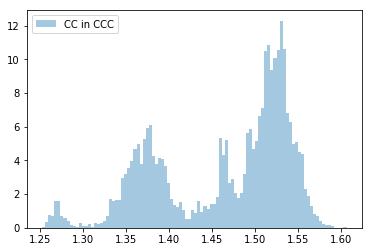

In [45]:
sns.distplot(dist_arr_CCN, bins=100, kde=False, norm_hist=True, label='CC in CCC')
plt.legend()
plt.show()

In [51]:
def gen_3JHC_list(df_idx, df_structures_idx, molecule_name):
    pairs_list = []
    df_tr = df_idx.loc[molecule_name]
    df_st = df_structures_idx.loc[molecule_name]

    if type(df_tr) == pd.Series:
        return []

    pairs_3J = df_tr.query('type == "{}"'.format('3JHC'))[['atom_index_0','atom_index_1','id']].values
    dist_matrix = get_dist_matrix(df_structures_idx, molecule_name)

    for p3 in pairs_3J:
        atom_idx_0 = p3[0] 
        con_id = p3[2] 

        dist_arr = dist_matrix[atom_idx_0] 
        mask = dist_arr != 0
        dist_arr_excl_0 = dist_arr[mask]
        masked_idx = df_st['atom_index'].values[mask]
        atom_idx_1 = masked_idx[np.argsort(dist_arr_excl_0)[0]]

        atom_idx_3 = p3[1]
        dist_arr = dist_matrix[atom_idx_3]
        candidate_atom_idx_2 = np.arange(len(dist_arr))[(dist_arr > 1.1) * (dist_arr < 1.65)]
        atom_idx_2 = candidate_atom_idx_2[np.argsort(dist_matrix[atom_idx_1][candidate_atom_idx_2])[0]]
        pair = [atom_idx_0, atom_idx_1, atom_idx_2, atom_idx_3, con_id]
        pairs_list.append(pair)

    return pairs_list

In [52]:
dist_arr_CCC = np.zeros(0)

for m in mols[:10000]: 
    dist_mat = get_dist_matrix(df_structures_idx, m)
    pairs_3j = gen_3JHC_list(df_idx, df_structures_idx, m) 
    if len(pairs_3j) == 0:
        continue
    center_pairs = np.array(pairs_3j)[:,1:3] 
    unique_paires = np.unique(center_pairs, axis=0)
    center_atoms_idx = np.unique(unique_paires)
    atoms = df_structures_idx.loc[m]['atom'].values 
    pickup_atoms = center_atoms_idx[atoms[center_atoms_idx] == "C"] 

    for p in unique_paires:
#         if np.isin(p, pickup_atoms).sum() / 2 == 1:
        dist_arr_CCC = np.hstack([dist_arr_CCC, dist_mat[p[0], p[1]]])

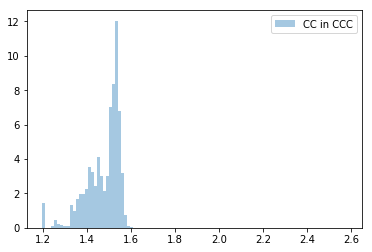

In [43]:
sns.distplot(dist_arr_CCC, bins=100, kde=False, norm_hist=True, label='CC in CCC')
# sns.distplot(dist_arr_CCN, bins=100, kde=False, norm_hist=True, label='CC in CCN')
# plt.xlim(1.1, 1.65)
plt.legend()
plt.show()

In [58]:
dist_arr_CC = np.zeros(0)

for m in mols[:10000]:
    atom_C_mask = df_structures_idx.loc[m]['atom'] == 'C'
    atom_C_idx = df_structures_idx.loc[m]['atom_index'].values[atom_C_mask]
    dist_mat = get_dist_matrix(df_structures_idx, m)

    if len(atom_C_idx) > 0:
        for i in atom_C_idx:
            for j in atom_C_idx:
                dist = dist_mat[j, i]
                if dist < 2:
                    dist_arr_CC = np.hstack([dist_arr_CC, dist])

In [59]:
np.sort(dist_arr_CC)

array([0.        , 0.        , 0.        , ..., 1.99645783, 1.99786489,
       1.99786489])

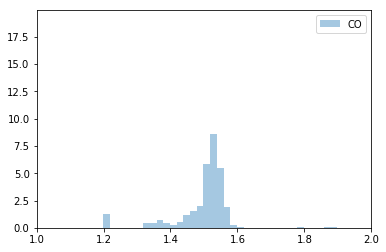

In [62]:
sns.distplot(dist_arr_CC, bins=100, kde=False, norm_hist=True, label='CO')
plt.legend()
plt.xlim(1, 2)
plt.show()

In [112]:
second_locs.shape

(5, 3, 3)

In [128]:
second_locs.shape

(5, 3, 3)

In [131]:
locs[second_idx][.shape

(5, 3, 3)

In [94]:
sorted_locs = locs[np.argsort(mat)]
origin = sorted_locs[:, 0]
nearest = sorted_locs[:, 1]
second = sorted_locs
base = nearest - origin
sec_vec = second - np.tile(origin, (5,1,1))
base_tile = np.tile(base, (5,1,1))
(base_tile * sec_vec).sum(axis=2) / np.linalg.norm(sec_vec, axis=2) / np.linalg.norm(base_tile, axis=2)

/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


array([[        nan,  0.81649832,  0.81649835,  0.81650128,  0.81649981],
       [-0.33333494,  1.        ,         nan,         nan,         nan],
       [-0.33335189,  1.        ,  0.81648214,  0.81649909,  0.81649952],
       [ 1.        ,  1.        ,  0.81648214,  0.81649909,  0.81649682],
       [-0.33334224,  1.        ,  0.81650324,  0.81650128,  0.81649981]])

In [91]:
base_tile.shape

(5, 3, 3)

In [79]:
np.tile(base.T, (1,1,1)) .shape

(1, 3, 5)

In [145]:
sorted_locs[:, 2:][:,0]

array([[-5.23813635e-01,  1.43793264e+00,  9.06397294e-01],
       [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
       [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
       [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
       [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01]])

In [141]:
locs

array([[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
       [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
       [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
       [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
       [-5.23813635e-01,  1.43793264e+00,  9.06397294e-01]])

In [35]:
np.tile(base, (5,1,1)).shape

(5, 5, 3)

In [28]:
(np.tile(base.T, (3,1,1)).T * sec_vec).sum(axis=1) / np.linalg.norm(sec_vec, axis=1) / np.linalg.norm(base, axis=1)

ValueError: operands could not be broadcast together with shapes (5,3) (5,) 

In [21]:

return (base * sec_vec).sum(axis=1) / np.linalg.norm(sec_vec, axis=1) / np.linalg.norm(base, axis=1)


array([[[-5.11115499e-01,  1.45063078e+00,  9.19095430e-01],
        [-7.40733150e-02,  3.77947004e-01, -1.08552758e+00],
        [-5.85057980e-03, -1.40323134e-02, -6.02487540e-03]],

       [[ 1.00958043e+00,  1.46160075e+00, -1.87384120e-03],
        [-5.34783751e-01,  1.45355793e+00, -8.70612398e-01],
        [-5.25789755e-01,  1.43595652e+00,  9.04421174e-01]],

       [[-1.00958043e+00, -1.01776216e+00, -1.00975472e+00],
        [-1.98756480e+00, -2.58185180e-02, -5.57353868e-01],
        [-5.41091644e-01,  1.44725004e+00, -8.76920290e-01]],

       [[ 5.42965485e-01,  5.34783751e-01,  5.42791189e-01],
        [-1.97134025e+00, -9.59397000e-03, -5.41129320e-01],
        [ 1.88837456e+00,  2.34039488e+00,  8.76920290e-01]],

       [[-1.70014345e-02,  1.97134025e+00, -3.52830081e-01],
        [-4.26201801e-01,  2.58185180e-02, -1.43765607e+00],
        [-9.04246878e-01, -9.12428612e-01, -9.04421174e-01]]])

In [174]:
get_angle(df_structures_idx, mols[0])

array([[ 1.        , -0.33334224, -0.33335189, -0.33333494],
       [ 1.        ,  0.81648268,  0.81649832,  0.81650188],
       [ 1.        ,  0.81648214,  0.81649835,  0.81650324],
       [ 1.        ,  0.81649582,  0.81649909,  0.81650128],
       [ 1.        ,  0.81649952,  0.81649682,  0.81649981]])

In [176]:
get_orientation(df_structures_idx, mols[0])

array([[ 1.        ,  1.        ,  0.50000392,  0.49999675],
       [ 1.        ,  1.        , -0.36236402, -0.36235604],
       [ 1.        ,  1.        , -0.36235995, -0.362357  ],
       [ 1.        ,  1.        , -0.36239269, -0.36233693],
       [ 1.        ,  1.        , -0.36239882, -0.36238805]])

In [173]:
def get_angle(df_structures_idx, mol):
    locs = df_structures_idx.loc[mol][['x','y','z']].values # ( ,3)
    mat = get_dist_matrix(df_structures_idx, mol)
    sorted_locs = locs[np.argsort(mat)]
    origin = sorted_locs[:, 0]
    nearest = sorted_locs[:, 1]
    second = sorted_locs[:, 2:]
    base = nearest - origin
    out_mat = np.zeros((0, len(mat)))
    for i in range(len(mat)-2):
        sec_vec = second[:,i,:] - origin
        out = (base * sec_vec).sum(axis=1) / np.linalg.norm(sec_vec, axis=1) / np.linalg.norm(base, axis=1)
        out_mat = np.vstack([out_mat, out])
    left = np.ones((len(mat), 1))
    return np.hstack([left, out_mat.T])

In [175]:
def get_orientation(df_structures_idx, mol):
    locs = df_structures_idx.loc[mol][['x','y','z']].values # ( ,3)
    mat = get_dist_matrix(df_structures_idx, mol)
    sorted_locs = locs[np.argsort(mat)]    
    
    origin = sorted_locs[:, 0]
    nearest = sorted_locs[:, 1]
    second = sorted_locs[:, 2]
    try:
        third = sorted_locs[:, 3:]
    except:
        return np.ones(len(sorted_locs))
    
    base = nearest - origin
    sec_vec = second - origin
    out_mat = np.zeros((0, len(mat)))
    left = np.ones((len(mat), 1))
    for i in range(len(mat)-3):
        thi_vec = third[:,i,:] - origin
        proj_1 = sec_vec - base * np.tile(np.linalg.norm(sec_vec, axis=1), (3,1)).T / np.tile(np.linalg.norm(base, axis=1), (3,1)).T
        proj_2 = thi_vec - base * np.tile(np.linalg.norm(thi_vec, axis=1), (3,1)).T / np.tile(np.linalg.norm(base, axis=1), (3,1)).T
        out = (proj_1*proj_2).sum(axis=1) / np.linalg.norm(proj_1, axis=1) / np.linalg.norm(proj_2, axis=1)
        out_mat = np.vstack([out_mat,out])
    return np.hstack([left, (np.hstack([left, out_mat.T]))])

In [12]:
get_orientation(df_structures_idx, mols[0])

array([ 0.50000392, -0.36236402, -0.36235995, -0.36239269, -0.36239882])

In [13]:
get_angle(df_structures_idx, mols[0])

array([-0.33334224,  0.81648268,  0.81648214,  0.81649582,  0.81649952])

In [14]:
mat

array([[0.        , 1.09195306, 1.09195162, 1.09194638, 1.09194754],
       [1.09195306, 0.        , 1.78311976, 1.7831475 , 1.78315669],
       [1.09195162, 1.78311976, 0.        , 1.78315766, 1.78314839],
       [1.09194638, 1.7831475 , 1.78315766, 0.        , 1.78314787],
       [1.09194754, 1.78315669, 1.78314839, 1.78314787, 0.        ]])

In [18]:
np.argsort(mat)

array([[0, 3, 4, 2, 1],
       [1, 0, 2, 3, 4],
       [2, 0, 1, 4, 3],
       [3, 0, 1, 4, 2],
       [4, 0, 3, 2, 1]])

In [19]:
locs[np.argsort(mat)][:, 0]

array([[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
       [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
       [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
       [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
       [-5.23813635e-01,  1.43793264e+00,  9.06397294e-01]])

In [20]:
locs[np.argsort(mat)]

array([[[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
        [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
        [-5.23813635e-01,  1.43793264e+00,  9.06397294e-01],
        [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
        [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03]],

       [[ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
        [-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
        [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
        [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
        [-5.23813635e-01,  1.43793264e+00,  9.06397294e-01]],

       [[ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
        [-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
        [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
        [-5.23813635e-01,  1.43793264e+00,  9.06397294e-01],
        [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01]],

       [[-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
        [-1.269813

In [65]:
origin = test[:,0]
nearest = test[:,1]
second = test[:,2]
base = nearest - origin
sec_vec = second - origin

In [106]:
sec_vec

array([[-5.11115499e-01,  3.52128486e-01,  8.98396298e-01],
       [ 1.00958043e+00,  1.46978248e+00, -1.69954560e-03],
       [-1.00958043e+00, -1.46978248e+00,  1.69954560e-03],
       [ 5.42965485e-01, -1.45355793e+00,  8.78619836e-01],
       [-1.70014345e-02,  9.59397000e-03, -1.78304101e+00]])

In [124]:
np.tile(np.linalg.norm(sec_vec, axis=1), (3,1)).T

array([[1.09194754, 1.09194754, 1.09194754],
       [1.78311976, 1.78311976, 1.78311976],
       [1.78311976, 1.78311976, 1.78311976],
       [1.7831475 , 1.7831475 , 1.7831475 ],
       [1.78314787, 1.78314787, 1.78314787]])

In [70]:
(base * sec_vec).sum(axis=1) / np.linalg.norm(sec_vec, axis=1) / np.linalg.norm(base, axis=1)

array([-0.33334224,  0.81648268,  0.81648214,  0.81649582,  0.81649952])

In [72]:
get_angle(test) 

array([-0.33334224,  0.81648268,  0.81648214,  0.81649582,  0.81649952])

In [37]:
locs[np.argsort(mat)[:, :3]]

array([[[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
        [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
        [-5.23813635e-01,  1.43793264e+00,  9.06397294e-01]],

       [[ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
        [-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
        [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04]],

       [[ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
        [-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
        [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03]],

       [[-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
        [-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
        [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03]],

       [[-5.23813635e-01,  1.43793264e+00,  9.06397294e-01],
        [-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
        [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01]]])